In [1]:
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=b9e94da9aba5fa03657a202b3a4316ca5dc377c342aeb4cda79c02477d633637
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [2]:
#install needed package for this project
!pip install imblearn

In [3]:
!pip install dtreeviz

     |████████████████████████████████| 51kB 4.7MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.1.3-cp36-none-any.whl size=52494 sha256=157a8e80170e9573e733dba9580698f5ed65f68d00e31a2151978dcc05d6a5b8
  Stored in directory: /root/.cache/pip/wheels/80/a9/1e/4751fda06e88399ee09410646e9d55c88787276f9537b8ebd0
Successfully built dtreeviz


In [4]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
MAX_MEMORY = "12g"
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", MAX_MEMORY) \
  .config("spark.driver.memory", MAX_MEMORY)\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size",MAX_MEMORY)\
  .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import StringIndexerModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from dtreeviz.models.spark_decision_tree import ShadowSparkTree
from dtreeviz import trees

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
# All data files shall be located in the following directory on 
# your google drive: /content/drive/My Drive/ist718_data/data_groupN

# The following provides 2 example file names and their full path names.  This example assumes the assigned
# group name is group12.  The definitions in this cell must be used to load all data files.
# This is only an example, change these definitions to match your file names.
train_csv = '/content/drive/My Drive/ist718_data/data_group5/train.csv'

In [6]:
# The third code cell of your notebook must contain code to mount your google drive and load the data files
from google.colab import drive
drive.mount('/content/drive')

# You must use the definitions above to load your data.
data_df = pd.read_csv(train_csv)

Mounted at /content/drive


In [7]:
enable_grid_search = False

### EDA & Data Visualization

In [8]:
#use pandas dataframe to do visualization
train = data_df

In [9]:
#check for dataset dimension
train.shape

(381109, 12)

In [10]:
#check for missing values
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [11]:
#check for descriptive stats
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of the Dependent Variable')

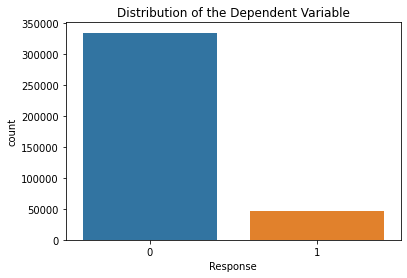

In [12]:
#plot the distribution of the target variable Response
sns.countplot(train.Response).set_title('Distribution of the Dependent Variable')

Text(0.5, 0.98, 'Barplot of Distribution of Dependent Variable by Gender')

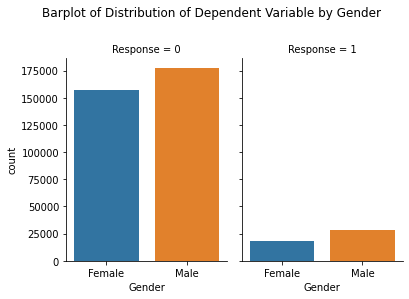

In [13]:
#plot the distribution of Response variable by gender
temp_df=train.groupby(['Gender','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
g = sns.catplot(x="Gender", y="count",col="Response",
                data=temp_df, kind="bar",
                height=4, aspect=.7);

plt.subplots_adjust(top=0.8)
g.fig.suptitle('Barplot of Distribution of Dependent Variable by Gender') 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Age Distribution')

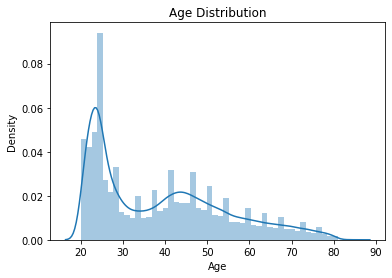

In [14]:
#check for age distribution
sns.distplot(train.Age).set_title('Age Distribution')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


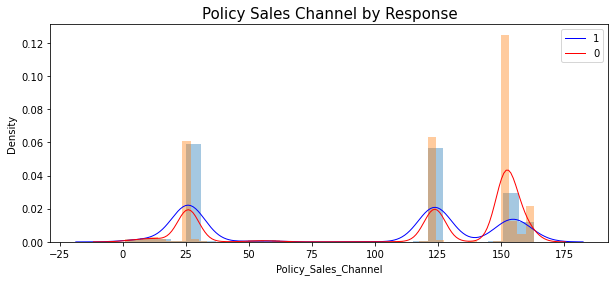

In [15]:
#check relationship between Response variable and Policy Sales Channel
temp_df = train
plt.figure(figsize = (10, 4))
sns.distplot(temp_df.loc[(temp_df['Response'] == 1), 'Policy_Sales_Channel'], kde_kws = {"color": "b", "lw": 1, "label": "1"})
sns.distplot(temp_df.loc[(temp_df['Response'] == 0), 'Policy_Sales_Channel'], kde_kws = {"color": "r", "lw": 1, "label": "0"})
plt.title('Policy Sales Channel by Response', fontsize = 15)
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Region Distribution')

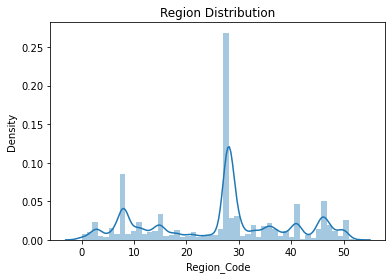

In [16]:
#check for region distribution
sns.distplot(train.Region_Code).set_title('Region Distribution')

Text(0.5, 1.0, 'Barplot of Driving License by Gender')

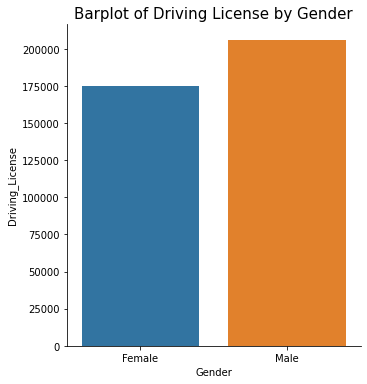

In [17]:
#distribution of Driving License variable by gender
temp_df=train.groupby(['Gender'])['Driving_License'].count().to_frame().reset_index()
sns.catplot(x="Gender", y="Driving_License",
                data=temp_df, kind="bar")
plt.title('Barplot of Driving License by Gender', fontsize = 15)

Text(0.5, 0.98, 'Distribution of Previously Insured by Vehicle Damage')

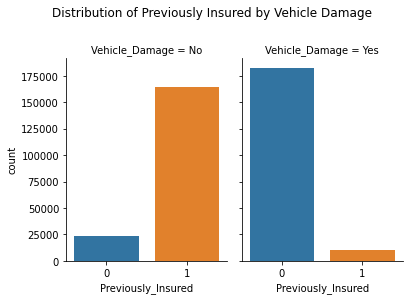

In [18]:
#distribution of Previously Insured variable by Vehicle Damage
temp_df=train.groupby(['Vehicle_Damage','Previously_Insured'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
g = sns.catplot(x="Previously_Insured", y="count",col="Vehicle_Damage",
                data=temp_df, kind="bar",
                height=4, aspect=.7);

plt.subplots_adjust(top=0.8)
g.fig.suptitle('Distribution of Previously Insured by Vehicle Damage') 

In [19]:
#encode categorical variables into numerical and apply changes to a temporary dataframe
temp_data = train
Gender = {'Male': 0, 'Female': 1}
Driving_License = {0: 0, 1: 1}
Previously_Insured = {0: 1, 1: 0}
Vehicle_Age = {'> 2 Years': 2, '1-2 Year': 1, '< 1 Year': 0}
Vehicle_Damage = {'Yes': 1, 'No': 0}

temp_data['Gender'] = temp_data['Gender'].map(Gender)
temp_data['Driving_License'] = temp_data['Driving_License'].map(Driving_License)
temp_data['Previously_Insured'] = temp_data['Previously_Insured'].map(Previously_Insured)
temp_data['Vehicle_Age'] = temp_data['Vehicle_Age'].map(Vehicle_Age)
temp_data['Vehicle_Damage'] = temp_data['Vehicle_Damage'].map(Vehicle_Damage)

temp_data['Policy_Sales_Channel'] = temp_data['Policy_Sales_Channel'].apply(lambda x: np.int(x))
temp_data['Region_Code'] = temp_data['Region_Code'].apply(lambda x: np.int(x))

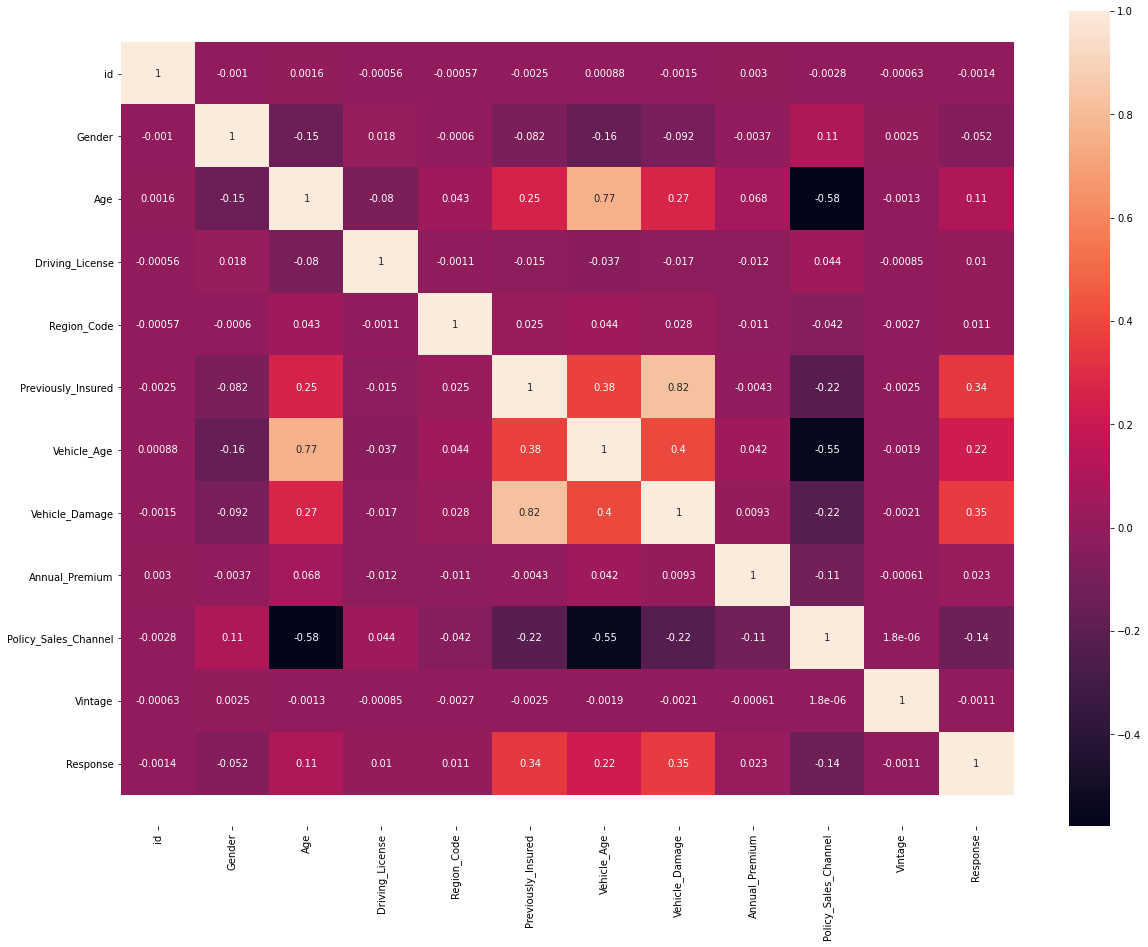

In [20]:
#check for correlation matrix
corrMatrix = temp_data.corr()
plt.subplots(figsize=(20,15))
ax = sns.heatmap(corrMatrix, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [21]:
#check for distribution of the Driving License variable
print("Percentage of Driving_License feature\n ")
print(train['Driving_License'].value_counts()/len(train)*100)

Percentage of Driving_License feature
 
1    99.786938
0     0.213062
Name: Driving_License, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


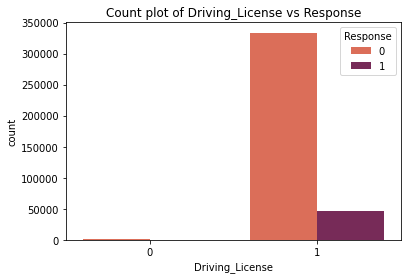

In [22]:
#count the number of response based on Driving License
f,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4))
#axx = ax.flatten()
plt.title("Count plot of Driving_License vs Response")
#sns.countplot(train['Driving_License'],ax = axx[0],palette = 'rocket')
sns.countplot('Driving_License', hue = 'Response',data = train,palette="rocket_r")

Text(0.5, 0.98, 'Barplot of Dependent Variable by Vehile Age')

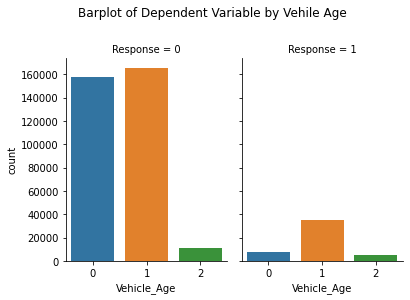

In [23]:
##plot distribution of the Response variable by Vehile Age
temp_df=train.groupby(['Vehicle_Age','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
g = sns.catplot(x="Vehicle_Age", y="count",col="Response",
                data=temp_df, kind="bar",
                height=4, aspect=.7);

plt.subplots_adjust(top=0.8)
g.fig.suptitle('Barplot of Dependent Variable by Vehile Age') 

In [24]:
#define age variable into different categories
ages = train['Age']
bins = [19, 30, 50, 90]
labels = ['Young', 'Middle Age', 'Elderly']
train['Age_bracket'] = pd.cut(ages, bins, labels = labels,include_lowest = True)

Text(0.5, 0.98, 'Barplot of Dependent Variable by Age Group')

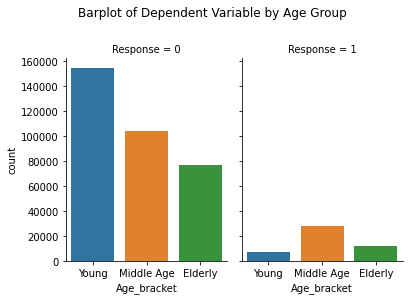

In [25]:
#distribution of the Response variable by age group
temp_df=train.groupby(['Age_bracket','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
g = sns.catplot(x="Age_bracket", y="count",col="Response",
                data=temp_df, kind="bar",
                height=4, aspect=.7);

plt.subplots_adjust(top=0.8)
g.fig.suptitle('Barplot of Dependent Variable by Age Group') 

In [26]:
#define Vintage variable into different categories by using quartiles
loyalty = train['Vintage']
bins = [0, 82, 154, 227, 300]
labels = ['q1', 'q2', 'q3','q4']
train['loyalty_bracket'] = pd.cut(loyalty, bins, labels = labels,include_lowest = True)

Text(0.5, 0.98, 'Barplot of Dependent Variable by Vintage')

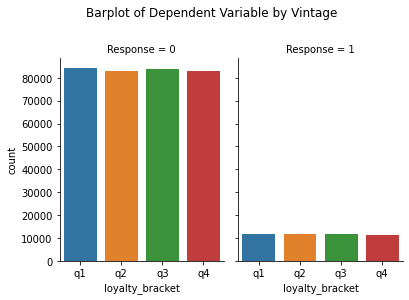

In [27]:
#distribution of the Response variable by Vintage
temp_df=train.groupby(['loyalty_bracket','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
g = sns.catplot(x="loyalty_bracket", y="count",col="Response",
                data=temp_df, kind="bar",
                height=4, aspect=.7);

plt.subplots_adjust(top=0.8)
g.fig.suptitle('Barplot of Dependent Variable by Vintage') 

### Data Processing

In [8]:
#convert data from pandas dataframe to spark dataframe for analysis and modeling
traindf = spark.createDataFrame(data_df)

In [9]:
display(traindf.toPandas().head())

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [10]:
#use StringIndexerModel to convert categorical variables into numerical

gender_pipe = StringIndexerModel.from_labels(['Female', 'Male'],
                                    inputCol="Gender",
                                    outputCol="Gender_encoded")

Vehicle_Age_pipe = StringIndexerModel.from_labels(['< 1 Year', '1-2 Year','> 2 Years'],
                                    inputCol="Vehicle_Age",
                                    outputCol="Vehicle_Age_encoded")

Vehicle_Damage_pipe = StringIndexerModel.from_labels(['No', 'Yes'],
                                    inputCol="Vehicle_Damage",
                                    outputCol="Vehicle_Damage_encoded")

one_hot_pipe = Pipeline(stages = [gender_pipe, Vehicle_Age_pipe, Vehicle_Damage_pipe])
traindf = one_hot_pipe.fit(traindf).transform(traindf)

In [11]:
#drop id column and original categorical columns
traindf = traindf.drop("id","Gender","Vehicle_Age","Vehicle_Damage")
#split dataset into train and val set by 70/30
train_df, val_df = traindf.randomSplit([0.7, 0.3])

In [12]:
#check for data types
train_df.printSchema()

root
 |-- Age: long (nullable = true)
 |-- Driving_License: long (nullable = true)
 |-- Region_Code: double (nullable = true)
 |-- Previously_Insured: long (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Policy_Sales_Channel: double (nullable = true)
 |-- Vintage: long (nullable = true)
 |-- Response: long (nullable = true)
 |-- Gender_encoded: double (nullable = false)
 |-- Vehicle_Age_encoded: double (nullable = false)
 |-- Vehicle_Damage_encoded: double (nullable = false)



In [13]:
#use VectorAssembler to combine all independent variables into a feature column.
preprocess_pipe = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['Age','Driving_License','Region_Code','Previously_Insured',
                                       'Annual_Premium','Policy_Sales_Channel','Vintage',
                                       'Gender_encoded','Vehicle_Age_encoded','Vehicle_Damage_encoded'],
                            outputCol='features')]).fit(train_df)

In [14]:
#apply changes to train and validation set
train_df = preprocess_pipe.transform(train_df)
val_df = preprocess_pipe.transform(val_df)

### Model

#### LR

In [15]:
#first build Logistic Regression model with default setting 
lr = LogisticRegression().setLabelCol('Response').setFeaturesCol('features')
lr_model = lr.fit(train_df)

In [16]:
#use AUC Score to check model performance
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="Response", metricName="areaUnderROC")
lr_pred = lr_model.transform(val_df)
print(evaluator.evaluate(lr_pred))

0.8325088822145161


In [17]:
#use classification report to check precision, recall and accuracy
y_true_lr = lr_pred.select(['Response']).collect()
y_pred_lr = lr_pred.select(['Prediction']).collect()

print(classification_report(y_true_lr,y_pred_lr))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100421
           1       0.38      0.00      0.00     14143

    accuracy                           0.88    114564
   macro avg       0.63      0.50      0.47    114564
weighted avg       0.82      0.88      0.82    114564



#### DT

In [ ]:
#build Decision Tree model and check its AUC score
dt = DecisionTreeClassifier().setLabelCol('Response').setFeaturesCol('features').setMaxDepth(7)
dt_model = dt.fit(train_df)

dt_pred = dt_model.transform(val_df)
print(evaluator.evaluate(dt_pred))

In [ ]:
#use classification report to get precision, recall and accuracy
y_true_dt = dt_pred.select(['Response']).collect()
y_pred_dt = dt_pred.select(['Prediction']).collect()

print(classification_report(y_true_dt,y_pred_dt))

#### Random Forest

In [ ]:
#build Random Forest model with default setting 
rf = RandomForestClassifier(labelCol="Response", featuresCol="features")
rf_model = rf.fit(train_df)

In [ ]:
#Evaluate the model
rf_pred = rf_model.transform(val_df)
print(evaluator.evaluate(rf_pred))

In [ ]:
#get precision, recall and accuracy of Random Forest
y_true_rf = rf_pred.select(['Response']).collect()
y_pred_rf = rf_pred.select(['Prediction']).collect()

print(classification_report(y_true_rf, y_pred_rf))

#### GBT

In [ ]:
#build GBTClassifier model
gbt = GBTClassifier(maxIter=10,labelCol='Response', featuresCol='features')
gbt_model = gbt.fit(train_df)

In [ ]:
#Evaluate the model using AUC
gbt_pred = gbt_model.transform(val_df)
print(evaluator.evaluate(gbt_pred))

In [ ]:
#get precision, recall and accuracy of GBT model
y_true_gbt = gbt_pred.select(['Response']).collect()
y_pred_gbt = gbt_pred.select(['Prediction']).collect()

print(classification_report(y_true_gbt, y_pred_gbt))

### PCA

In [ ]:
#normalize and standardlize the train set and get pca score
normal = feature.Normalizer(inputCol='features', outputCol='nfeatures')
standardize = feature.StandardScaler(withMean=True, withStd=False, inputCol='nfeatures', outputCol='zfeatures')
pca = feature.PCA(k=2, inputCol='zfeatures', outputCol='pca')

pipe_pca = Pipeline(stages=[normal, standardize, pca])
pca_model = pipe_pca.fit(train_df)
train_pca = pca_model.transform(train_df)

In [ ]:
#create 2D PCA visualization and check for data points distribution
P = np.array(train_pca.select('pca').rdd.map(lambda x: x['pca']).collect())
color = np.array(train_pca.select('Response').rdd.map(lambda x: x['Response']).collect())

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
sc = ax.scatter(P[:,0], P[:,1], c=color, alpha=0.6, s=10)
fig.suptitle("PC2 Scores vs. PC1 Scores", y=.92)
fig.colorbar(sc)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

plt.show()

### Undersampling

In [ ]:
#%%bash

#pip install imblearn

In [ ]:
#since we are dealing with a very unbalanced data, we use undersampling technique to resample our data
#it will take part of the majority class data
undersampleDF = traindf
undersampleDF_Pandas = undersampleDF.toPandas()

In [ ]:
#split the original data into two sub dataframe, one contains all independent variables and one contains target variable
X = undersampleDF_Pandas.filter(items=['Age','Driving_License','Region_Code','Previously_Insured',
                                       'Annual_Premium','Policy_Sales_Channel','Vintage',
                                       'Gender_encoded','Vehicle_Age_encoded','Vehicle_Damage_encoded'])
y = undersampleDF_Pandas.filter(items=['Response'])

In [ ]:
X.shape,y.shape

In [ ]:
#split original dataset into train and validation set by 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

In [ ]:
#build undersampler
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=0)

In [ ]:
#apply undersampling on train set
X_train_res, y_train_res = undersample.fit_resample(X_train, y_train)

In [ ]:
#Coonvert the resampled data into two dataframes
df_1=pd.DataFrame(X_train_res,columns=['Age','Driving_License','Region_Code','Previously_Insured',
                                       'Annual_Premium','Policy_Sales_Channel','Vintage',
                                       'Gender_encoded','Vehicle_Age_encoded','Vehicle_Damage_encoded'])
df_2=pd.DataFrame(y_train_res,columns=['Response'])
#merge the resampled feature data and resampled target data
result=df_1.combine_first(df_2)
#convert it back to spark dataframe
train_new = spark.createDataFrame(result)

In [ ]:
#for resampled train set, check target variable distribution
responses = train_new.groupBy('Response').count().collect()
responses

In [ ]:
#use the initial 30% of the original data as validation set
val_set = X_test.combine_first(y_test)
validation_df = spark.createDataFrame(val_set)

In [ ]:
#for resampled data, use VectorAssembler to combine all independent variables into a feature column.
pipe_1 = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['Age','Driving_License','Region_Code','Previously_Insured',
                                       'Annual_Premium','Policy_Sales_Channel','Vintage',
                                       'Gender_encoded','Vehicle_Age_encoded','Vehicle_Damage_encoded'],
                           outputCol='features')]).fit(train_new)

train_new = pipe_1.transform(train_new)
validation_df = pipe_1.transform(validation_df)

#### DT Undersampling

In [ ]:
#use resampled data to rerun the previous Decision Tree model and check the performance
dt_model_1 = dt.fit(train_new)

### Evaluation model.
pred = dt_model_1.transform(validation_df)
print(evaluator.evaluate(pred))

In [ ]:
#print the tree output
print(dt_model_1.toDebugString)

In [ ]:
#apply grid search on Decision Tree, using resampled data
if enable_grid_search:
  dt_grid = ParamGridBuilder().addGrid(dt.maxDepth, [5, 10, 15, 20]).addGrid(dt.maxBins, [10, 20, 30, 40]).build()
  all_dt_models = []
  for i in range(len(dt_grid)):
    model = dt.fit(train_new, dt_grid[i])
    all_dt_models.append(model)
  dt_auc = []
  for m in all_dt_models:
    new_dt_model = m.transform(validation_df)
    dt_auc.append(evaluator.evaluate(new_dt_model))
  best_model_idx = np.argmax(dt_auc)
  print("best model index =", best_model_idx)
  print(dt_grid[best_model_idx])
  pass

In [ ]:
#record the grid search output and build the best Decision Tree model
dt_maxdepth = 10
dt_maxbins = 10

optimal_dt = DecisionTreeClassifier().setLabelCol('Response').setFeaturesCol('features').setMaxDepth(dt_maxdepth).setMaxBins(dt_maxbins)
best_dt_model = optimal_dt.fit(train_new)
best_dt_pred = best_dt_model.transform(validation_df)
print(evaluator.evaluate(best_dt_pred))

In [ ]:
#recheck the precision, recall and accuracy
best_y_true_dt = best_dt_pred.select(['Response']).collect()
best_y_pred_dt = best_dt_pred.select(['Prediction']).collect()

print(classification_report(best_y_true_dt,best_y_pred_dt))

In [ ]:
#In order to answer one of our prediction questions, we want to visualize the Decision tree output
#We have tried to plot the tree of the best model, but there are too many nodes and it's really hard to interpret it
#we rebuild a dt model with max depth = 5 and max bins = 5 and get its visualized output, now the size of the tree is manageable
dtviz_maxdepth = 5
dtviz_maxbins = 5

viz_dt = DecisionTreeClassifier().setLabelCol('Response').setFeaturesCol('features').setMaxDepth(dtviz_maxdepth).setMaxBins(dtviz_maxbins)
viz_dt_model = viz_dt.fit(train_new)
viz_dt_pred = viz_dt_model.transform(validation_df)

In [ ]:
features = ['Age','Driving_License','Region_Code','Previously_Insured','Annual_Premium','Policy_Sales_Channel','Vintage','Gender_encoded','Vehicle_Age_encoded','Vehicle_Damage_encoded']
target = "Response"
viz_df = viz_dt_pred.toPandas()[features + [target]]

In [ ]:
spark_dtree = ShadowSparkTree(viz_dt_model, viz_df[features], viz_df[target], feature_names=features, target_name=target, class_names=[0, 1])

In [ ]:
trees.dtreeviz(spark_dtree, fancy=False)

#### LR Undersampling

In [ ]:
#rerun the previous Logistic Regression model using resampled data
lr_model_1 = lr.fit(train_new)
#Evaluate model.
lr_pred = lr_model_1.transform(validation_df)
print(evaluator.evaluate(lr_pred))

In [ ]:
#grid search of Logistic Regression
if enable_grid_search:
  lr_grid = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.02, 0.04, 0.06]).addGrid(lr.elasticNetParam, [0.0, 0.3, 0.6, 0.9]).build()
  all_lr_models = []
  for i in range(len(lr_grid)):
    model = lr.fit(train_new, lr_grid[i])
    all_lr_models.append(model)
  lr_auc = []
  for m in all_lr_models:
    new_lr_model = m.transform(validation_df)
    lr_auc.append(evaluator.evaluate(new_lr_model))
  best_model_idx = np.argmax(lr_auc)
  print("best model index =", best_model_idx)
  print(lr_grid[best_model_idx])
  pass

In [ ]:
#Logistic Regression best model
optimal_lr = LogisticRegression().setLabelCol('Response').setFeaturesCol('features').setRegParam(0.0).setElasticNetParam(0.9)
best_lr_model = optimal_lr.fit(train_new)
best_lr_pred = best_lr_model.transform(validation_df)
print(evaluator.evaluate(best_lr_pred))

In [ ]:
#check precision, recall and accuracy of the best model
best_y_true_lr = best_lr_pred.select(['Response']).collect()
best_y_pred_lr = best_lr_pred.select(['Prediction']).collect()

print(classification_report(best_y_true_lr,best_y_pred_lr))

In [ ]:
#get feature imporeance
#LR model uses coefficients to meature feature importance
lr_feature_importances = best_lr_model.coefficients
lr_feature_imp_array = lr_feature_importances.toArray()
print(lr_feature_imp_array)

In [ ]:
#create a list of all feature names
predictors = ['Age','Driving_License','Region_Code','Previously_Insured','Annual_Premium','Policy_Sales_Channel','Vintage',
                                       'Gender_encoded','Vehicle_Age_encoded','Vehicle_Damage_encoded']

#combine the feature name with its importance                                       
lr_feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(predictors, abs(lr_feature_imp_array)):
    lr_feats[feature] = importance

#get the feature importance plot
lr_importances = pd.DataFrame.from_dict(lr_feats, orient='index').rename(columns={0: 'Gini-importance'})
lr_importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, title='LR feature importance')

#### RF Undersampling

In [ ]:
#rerun the previous Random Forest model using resampled data
rf_model_1 = rf.fit(train_new)
#Evaluate model.
rf_pred = rf_model_1.transform(validation_df)
print(evaluator.evaluate(rf_pred))

In [ ]:
#Random Forest grid search
if enable_grid_search:
  rf_grid = ParamGridBuilder().addGrid(rf.numTrees, [10, 30, 50, 80]).addGrid(rf.maxDepth, [5, 10, 15]).addGrid(rf.maxBins, [10, 20, 30]).build()
  all_rf_models = []
  for i in range(len(rf_grid)):
    model = rf.fit(train_new, rf_grid[i])
    all_rf_models.append(model)
  rf_auc = []
  for m in all_rf_models:
    new_rf_model = m.transform(validation_df)
    rf_auc.append(evaluator.evaluate(new_rf_model))
  best_model_idx = np.argmax(rf_auc)
  print("best model index =", best_model_idx)
  print(rf_grid[best_model_idx])
  pass

In [ ]:
#optimal RF model
num_trees = 80
max_depth = 10
max_bins = 30

optimal_rf = RandomForestClassifier().setLabelCol('Response').setFeaturesCol('features').setNumTrees(num_trees).setMaxDepth(max_depth).setMaxBins(max_bins)
best_rf_model = optimal_rf.fit(train_new)
best_rf_pred = best_rf_model.transform(validation_df)
print(evaluator.evaluate(best_rf_pred))

In [ ]:
#optimal RF model Precision, Recall, accuracy
best_rf_y_true = best_rf_pred.select(['Response']).collect()
best_rf_y_pred = best_rf_pred.select(['prediction']).collect()

print(classification_report(best_rf_y_true, best_rf_y_pred))

In [ ]:
#get feature importance of the optimal RF model
rf_feature_importances = best_rf_model.featureImportances
rf_feature_imp_array = rf_feature_importances.toArray()
print(rf_feature_imp_array)

In [ ]:
#combine the feature name with its importance
rf_feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(predictors, rf_feature_imp_array):
    rf_feats[feature] = importance

#get the feature importance plot
rf_importances = pd.DataFrame.from_dict(rf_feats, orient='index').rename(columns={0: 'Gini-importance'})
rf_importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, title='RF feature importance')

#### GBT Undersampling

In [ ]:
#rerun the previous GBT model using resampled data
gbt_model_1 = gbt.fit(train_new)
gbt_pred = gbt_model_1.transform(validation_df)
print(evaluator.evaluate(gbt_pred))

In [ ]:
#GBT model grid search
if enable_grid_search:
  gbt_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [int(x) for x in np.linspace(start = 2, stop = 10, num = 4)]) \
    .addGrid(gbt.maxBins, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(gbt.maxIter, [int(x) for x in np.linspace(start = 5, stop = 15, num = 3)]) \
    .build()
  all_gbt_models = []
  for i in range(len(gbt_grid)):
    model = gbt.fit(train_new, gbt_grid[i])
    all_gbt_models.append(model)
  gbt_auc = []
  for m in all_gbt_models:
    new_gbt_model = m.transform(validation_df)
    gbt_auc.append(evaluator.evaluate(new_gbt_model))
  best_model_idx = np.argmax(gbt_auc)
  print("best model index =", best_model_idx)
  print(gbt_grid[best_model_idx])
  pass

In [ ]:
#optimal gbt model
max_iter = 15
gbt_max_depth = 7
gbt_max_bins = 50

optimal_gbt = GBTClassifier().setLabelCol('Response').setFeaturesCol('features').setMaxIter(max_iter).setMaxDepth(gbt_max_depth).setMaxBins(gbt_max_bins)
best_gbt_model = optimal_gbt.fit(train_new)
best_gbt_pred = best_gbt_model.transform(validation_df)
print(evaluator.evaluate(best_gbt_pred))

In [ ]:
#optimal GBDT model Recall, precision and accuracy
best_gbt_y_true = best_gbt_pred.select(['Response']).collect()
best_gbt_y_pred = best_gbt_pred.select(['prediction']).collect()

print(classification_report(best_gbt_y_true, best_gbt_y_pred))

In [ ]:
#get feature importance of the optimal GBT model
gbt_feature_importances = best_gbt_model.featureImportances
gbt_feature_imp_array = gbt_feature_importances.toArray()
print(gbt_feature_imp_array)

In [ ]:
#combine the feature name with its importance
gbt_feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(predictors, gbt_feature_imp_array):
    gbt_feats[feature] = importance

#get the feature importance plot
gbt_importances = pd.DataFrame.from_dict(gbt_feats, orient='index').rename(columns={0: 'Gini-importance'})
gbt_importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, title='GBT feature importance')

### Appendix

In order to resample our data, we also tried the other two approaches, which are Oversampling and the combination of Over&Under Sampling. But our models perform better by using the Undersampling technique. These are the related code of the other two resampling approaches:

In [ ]:
#Oversampling
#SMOTE
#sm = SMOTE(random_state=0)
#X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#Random over sampler
#ros=RandomOverSampler(random_state=0)
#X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

#ADASYN
#ada=ADASYN(random_state=0)
#X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)

#print('Over sampled dataset shape：{}'.format(Counter(y_train_res)))
#clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
#clf_rf.fit(x_train_res, y_train_res)
#y_train_res.shape

In [ ]:
#Over&Under Sampling
#from imblearn.combine import SMOTETomek, SMOTEENN
#import imblearn.under_sampling

#SMOTEENN tends to clean more noisy samples than SMOTETomek.

#resample1 = SMOTEENN(random_state=42)

#train_df_res = train_df.drop('features')

#X = np.array(train_df_res.select('Age','Driving_License','Region_Code','Previously_Insured','Annual_Premium','Policy_Sales_Channel','Vintage','Gender_encoded','Vehicle_Age_encoded','Vehicle_Damage_encoded').collect())
#Y = np.array(train_df_res.select('Response').collect())

#X_res, Y_res = resample1.fit_resample(X,Y)

In [ ]:
#resample2 = SMOTETomek(random_state=42)
#X_res1, Y_res1 = resample2.fit_resample(X,Y)

#unique, counts = np.unique(Y_res1, return_counts=True)
#print(np.asarray((unique, counts)).T)

In [ ]:
#train_res = pd.DataFrame(data=X_res1, columns=['Age','Driving_License','Region_Code','Previously_Insured','Annual_Premium','Policy_Sales_Channel','Vintage','Gender_encoded','Vehicle_Age_encoded','Vehicle_Damage_encoded'])
#train_res['Response'] = Y_res1
#train_res = spark.createDataFrame(train_res)